<h1 align="center"> Tumor detection from MRI images </h1>
<p>
</p>
<h2> Data set explanations: </h2>
<p>
</p>
<li> The dataset consists of MRI images of the brain captured in three different directions: axial, coronal, and sagittal. 
These images display both benign (0: negative) and malignant (1: positive) tumors. The goal is to detect and classify 
tumors as either positive or negative. The dataset is organized into two main folders: one for training data and another 
for validation data. Each folder contains two subfolders, one for images and the other for labels. The images folder 
holds the MRI images, while the labels folder contains text files in YOLO format, which provide the coordinates of 
the bounding boxes for the tumors.</li>


<h3> Methods used in this project : </h3>   
<ul>    
<li> YOLOv8  </li>
<li> Faster RCNN </li>
</ul>           
      
<p>
</p>          
<li> <strong> Important Note: </strong> To speed up the training process, I utilize the GPU provided by Kaggle. Therefore, 
the directories and paths mentioned in the script are specific to Kaggle. However, you have the flexibility to modify these
directories and paths according to your preferences if you want to run the script on a different platform or adjust the 
file locations to suit your needs.</li>          
          

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
!pip install ultralytics
!pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.1/593.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 22.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 10.3 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=a15a98caa0252a813e

In [2]:
import os
import pandas as pd
import cv2
import random
import torch
import shutil
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import torch
from torch_snippets import *
import glob
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as TF

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# if not os.path.exists('/kaggle/working/output'):
#     os.mkdir('/kaggle/working/output')

In [3]:
# making output directories for training and validation 
# os.mkdir("/kaggle/working/datasets")
os.mkdir("/kaggle/working/train")
os.mkdir("/kaggle/working/train/images")
os.mkdir("/kaggle/working/train/labels")
os.mkdir("/kaggle/working/valid")
os.mkdir("/kaggle/working/valid/images")
os.mkdir("/kaggle/working/valid/labels")

In [7]:
# os.rmdir("/kaggle/working/datasets/images/train")
# shutil.rmtree("/kaggle/working/output")

In [ ]:
<li> Copying the data from input directory to the output ones that were already created </li>

In [4]:
def copy_folder_contents(source_folder, destination_folder):
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Iterate over the files and subdirectories in the source folder
    for item in os.listdir(source_folder):
        source_item = os.path.join(source_folder, item)
        destination_item = os.path.join(destination_folder, item)

        # If the item is a file, copy it to the destination folder
        if os.path.isfile(source_item):
            shutil.copy2(source_item, destination_item)
        
        # If the item is a subdirectory, recursively copy its contents to the destination folder
        if os.path.isdir(source_item):
            copy_folder_contents(source_item, destination_item)

# Example usage
#  --------------  train   ------------------------- 
source_folder = '/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/train'
destination_folder = "/kaggle/working/train/images"
copy_folder_contents(source_folder, destination_folder)


source_folder = '/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/train'
destination_folder = "/kaggle/working/train/labels"
copy_folder_contents(source_folder, destination_folder)


#  --------------  valid   ------------------------- 
source_folder = '/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test'
destination_folder = "/kaggle/working/valid/images"
copy_folder_contents(source_folder, destination_folder)


source_folder = '/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/test'
destination_folder = "/kaggle/working/valid/labels"
copy_folder_contents(source_folder, destination_folder)

<li> There are some images with missing labels, the function below tries to remove those images </li>

In [5]:
def remove_image_missing_label(images_folder, labels_folder):

    # Get a list of all image files in the images folder
    image_files = os.listdir(images_folder)

    # Iterate over the image files
    for image_file in image_files:
        # Get the corresponding label file name by replacing the image file extension with ".txt"
        label_file = os.path.splitext(image_file)[0] + ".txt"

        # Check if the label file exists in the labels folder
        if not os.path.exists(os.path.join(labels_folder, label_file)):
            # If the label file is missing, remove the image file
            os.remove(os.path.join(images_folder, image_file))
            print(f"Removed image file: {image_file}")
    

In [6]:
images_folder_train = "/kaggle/working/train/images"
labels_folder_train = "/kaggle/working/train/labels"

remove_image_missing_label(images_folder_train, labels_folder_train)

images_folder_valid = "/kaggle/working/valid/images"
labels_folder_valid = "/kaggle/working/valid/labels"

remove_image_missing_label(images_folder_valid, labels_folder_valid)

Removed image file: 00360_129.jpg

Removed image file: 00406_98.jpg

Removed image file: 00360_108.jpg

Removed image file: 00360_115.jpg

Removed image file: 00364_120.jpg

Removed image file: 00360_126.jpg

Removed image file: 00364_113.jpg

Removed image file: 00360_120.jpg

Removed image file: 00364_125.jpg

Removed image file: 00360_122.jpg

Removed image file: 00360_114.jpg

Removed image file: 00364_119.jpg

Removed image file: 00364_127.jpg

Removed image file: 00364_107.jpg

<li> This section plot the images with bounding box around the tumor and specify the lables</li>

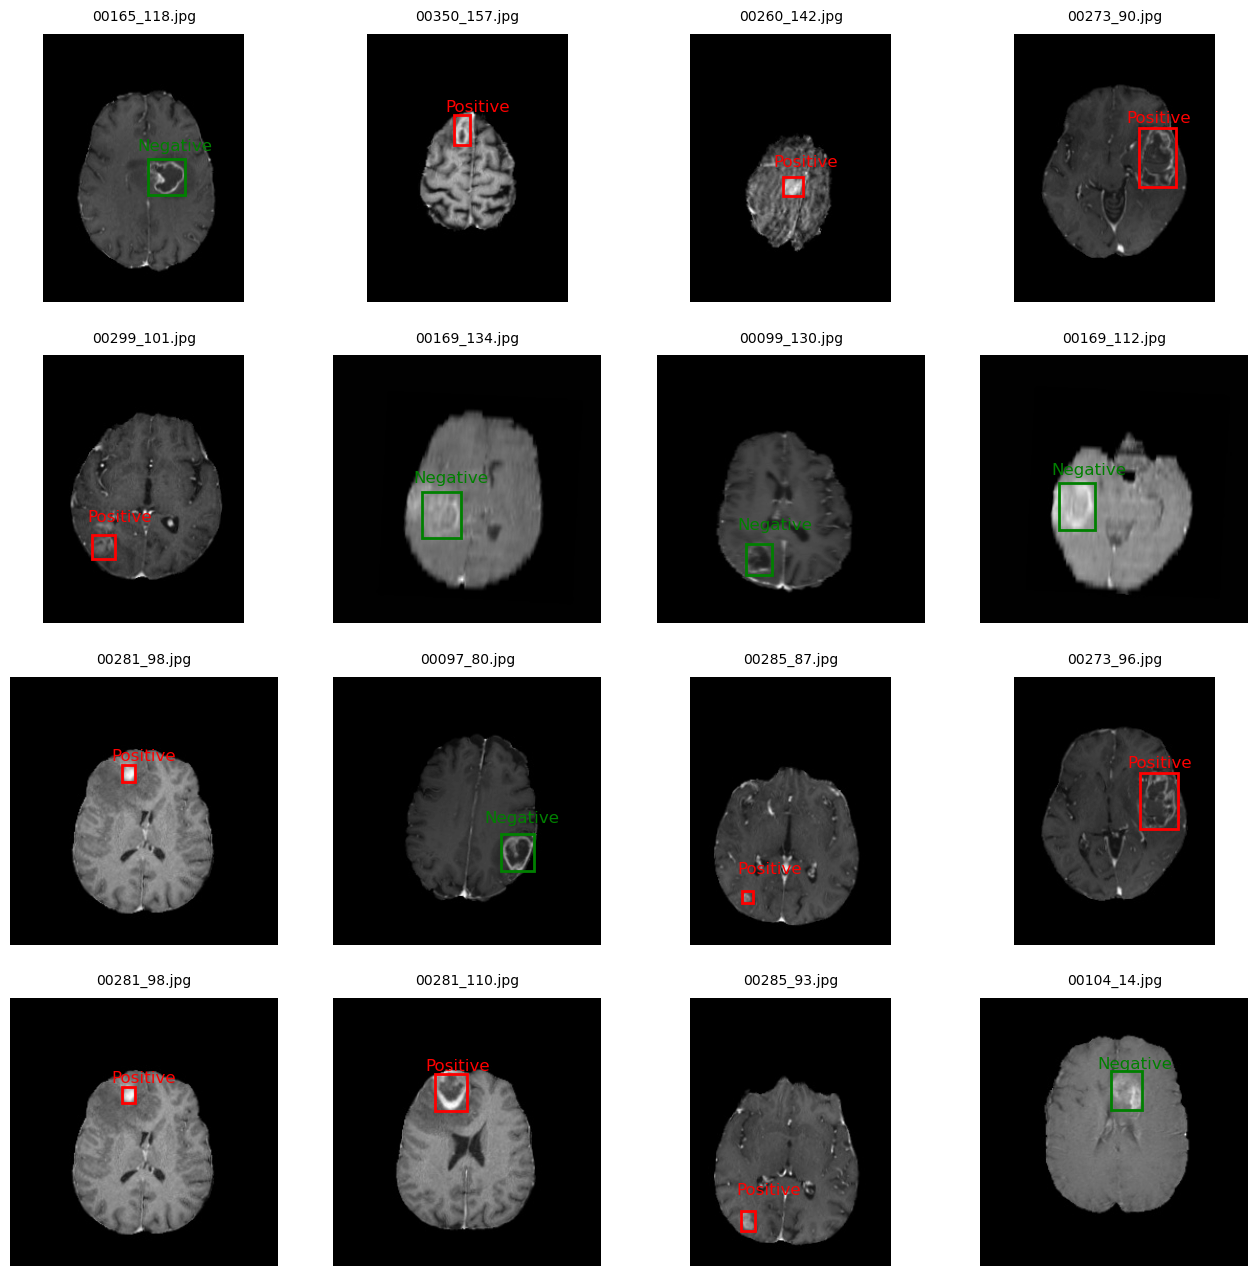

In [7]:
label_dict = {0: 'Negative', 1: 'Positive'}

def plot_obj_box(path_image, path_label):

    images = os.listdir(path_image)

    # Define the size of the figure and subplots
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))


    # Loop through each subplot and plot the image with a box
    for i, ax in enumerate(axs.flat):
        # Load the image for the current subplot

#         random.seed(10)
        random_image = random.sample(images, 1)
        img_path = os.path.join(path_image, str(random_image[0]))
        image = cv2.imread(img_path)
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    #     img = plt.imread(f'image_{i+1}.jpg')
        # Plot the image
        ax.imshow(gray_img, cmap='gray')
        ax.text(0.5, 1.05, random_image[0], transform=ax.transAxes, ha='center')
                
        # Get the coordinates for the box for the current subplot

        label_file = os.path.splitext(random_image[0])[0] + ".txt"
        label_path = os.path.join(path_label, label_file)

        coords = []

        try: 
            with open(label_path, "r") as f:
                for line in f:
                    coords.append(list(map(float, line.strip().split())))      

                for j in range(len(coords)):
                    label, X_center, Y_center, width, height = coords[j] 

                    x1 = int((X_center - width/2)  * image.shape[1])
                    x2 = int((X_center + width/2)  * image.shape[1])
                    y1 = int((Y_center - height/2) * image.shape[0])
                    y2 = int((Y_center + height/2) * image.shape[0])
                    
                    if label == 1 :
                        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
                        label_x, label_y = 0.9 * x1  , 0.9 * y1 
                        ax.text(label_x, label_y, label_dict[label], color='r', fontsize=12, verticalalignment='center')
                    else:
                        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
                        label_x, label_y = 0.9 * x1 , 0.9 * y1   
                        ax.text(label_x, label_y, label_dict[label], color='g', fontsize=12, verticalalignment='center')
                        
                    ax.add_patch(rect)
                    ax.axis('off')
        except:
            continue
    plt.show()
    

plot_obj_box(images_folder_train, labels_folder_train)
    

<h3> Data Augmentation </h3>

<li> Since there is no enough images to train, I generated new images with vertical and horizontal rotation of original images ans also revsing the bounding box coordinates as we rotate images. </li>

In [11]:
def h_flip_image(image):

    image = TF.hflip(image)
    return image

def v_flip_image(image):
    
    image = TF.vflip(image)
    return image

def h_flip_bbox(image, label):
    
    w, h = image.size
    x, y, cw, ch = label
    x_absolute = x * w
    label = (w - x_absolute)/w , y, cw, ch
    return label

def v_flip_bbox(image, label):
    
    w, h = image.size
    x, y, cw, ch = label
    image = TF.hflip(image)
    y_absolute = y * h
    label = x ,(h - y_absolute)/h, cw, ch
    return label


def Image_augmentation(image_folder, label_folder):
    # Get a list of image files in the image folder
    image_files = os.listdir(image_folder)

    # Iterate over each image file
    for image_file in image_files:
        # Load the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        image_height, image_width,_ = img.shape
        image = Image.open(image_path)
        
        rotated_image_h  = h_flip_image(image)
        rotated_image_v  = v_flip_image(image)


        rotated_image_name = f'{os.path.splitext(image_file)[0]}_rotated_h.jpg'
        rotated_image_path = os.path.join(image_folder, rotated_image_name)
        rotated_image_h.save(rotated_image_path)

        rotated_image_name = f'{os.path.splitext(image_file)[0]}_rotated_v.jpg'
        rotated_image_path = os.path.join(image_folder, rotated_image_name)
        rotated_image_v.save(rotated_image_path)


        # Update the corresponding YOLO label file
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(label_folder, label_file)
        if os.path.exists(label_path):
            # Read the YOLO label file
            with open(label_path, 'r') as f:
                lines = f.readlines()
                

            # Update the label coordinates based on the rotation
            rotated_lines_h = []
            rotated_lines_v = []
            for line in lines:
                line_parts = line.split()
                class_id = line_parts[0]
                x = float(line_parts[1])
                y = float(line_parts[2])
                width = float(line_parts[3])
                height = float(line_parts[4])
                bb_box = [x, y, width, height]
                
                
                revised_bbox_h = h_flip_bbox(image, bb_box)
                revised_bbox_v = v_flip_bbox(image, bb_box)
                
                
                x_cent_rot_h, y_cent_rot_h, width_rot_h, height_rot_h = revised_bbox_h
                x_cent_rot_v, y_cent_rot_v, width_rot_v, height_rot_v = revised_bbox_v


                # Append the rotated label line
                rotated_line_h = f'{class_id} {x_cent_rot_h} {y_cent_rot_h} {width_rot_h} {height_rot_h}\n'
                rotated_lines_h.append(rotated_line_h)
                
                rotated_line_v = f'{class_id} {x_cent_rot_v} {y_cent_rot_v} {width_rot_v} {height_rot_v}\n'
                rotated_lines_v.append(rotated_line_v)
                

            # Save the rotated YOLO label with the prefix 'label_name_rotated_x'
            rotated_label_name = f'{os.path.splitext(label_file)[0]}_rotated_h.txt'
            rotated_label_path_h = os.path.join(label_folder, rotated_label_name)
                      
            rotated_label_name = f'{os.path.splitext(label_file)[0]}_rotated_v.txt'
            rotated_label_path_v = os.path.join(label_folder, rotated_label_name)
            
            with open(rotated_label_path_h, 'w') as f:
                f.writelines(rotated_lines_h)
                
            with open(rotated_label_path_v, 'w') as f:
                f.writelines(rotated_lines_v)


In [12]:
# Data augmentation

Image_augmentation (images_folder_train, labels_folder_train)

<h2> YOLOv8 </h2>

In [13]:
tumor_yaml = f"""
    path : /kaggle/working
    train: /kaggle/working/train
    val: /kaggle/working/valid
    nc: 2
    names: 
        0 : negative
        1 : positive
    """

with open('tumor.yaml', 'w') as f:
    f.write(tumor_yaml)
    
%cat tumor.yaml


    path : /kaggle/working
    train: /kaggle/working/train
    val: /kaggle/working/valid
    nc: 2
    names: 
        0 : negative
        1 : positive
    

In [14]:
# os.remove("/kaggle/working/tumor.yaml")

In [15]:
 # Loading a pretrained model
yaml_path = "/kaggle/working/tumor.yaml"

model = YOLO('yolov8n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# # Training the model
model.train(data = yaml_path,
            epochs = 10,
            batch = 16,
            workers = 4)

# model.train(data ='tumor.yaml', epochs = 30)

100%|██████████| 6.23M/6.23M [00:00<00:00, 149MB/s]
Ultralytics YOLOv8.0.112 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/tumor.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=tor

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias
train: Scanning /kaggle/working/train/labels... 888 images, 0 backgrounds, 0 corrupt: 100%|██████████| 888/888 [00:00<00:00, 1546.50it/s]
train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/valid/labels... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 633.96it/s]
val: New cache created: /kaggle/working/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Si

In [17]:
model.val(data = yaml_path)

Ultralytics YOLOv8.0.112 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
val: Scanning /kaggle/working/valid/labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                   all         75         81      0.793      0.914      0.933      0.695
              negative         75         81      0.793      0.914      0.933      0.695
Speed: 6.3ms preprocess, 3.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/val2


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7a284b9c2320>
fitness: 0.7184328765557557
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.69463,     0.69463])
names: {0: 'negative', 1: 'positive'}
plot: True
results_dict: {'metrics/precision(B)': 0.793284534936147, 'metrics/recall(B)': 0.9135802469135802, 'metrics/mAP50(B)': 0.932659949689766, 'metrics/mAP50-95(B)': 0.6946298684297546, 'fitness': 0.7184328765557557}
save_dir: » runs/detect/val2
speed: {'preprocess': 6.315603256225586, 'inference': 3.0112075805664062, 'loss': 0.0021076202392578125, 'postprocess': 4.157511393229166}

<ul>-----------------------------------------------------------------------------</ul>
<strong> Validation metrics obtained by YOLOv8: 
<ul>
</ul>
<ul>    
<li> mAP50     : 0.93  </li>
<li> mAP95     : 0.70  </li>
<li> recall    : 0.91  </li>
<li> precision : 0.80  </li>
</ul> </strong>
<ul>-----------------------------------------------------------------------------</ul>

In [20]:
# confusion_matrix = Image.open("/kaggle/working/runs/detect/train/confusion_matrix.png")
# plt.figure(figsize=(20,10))
# plt.imshow(confusion_matrix)
# plt.axis(False)
# plt.show()

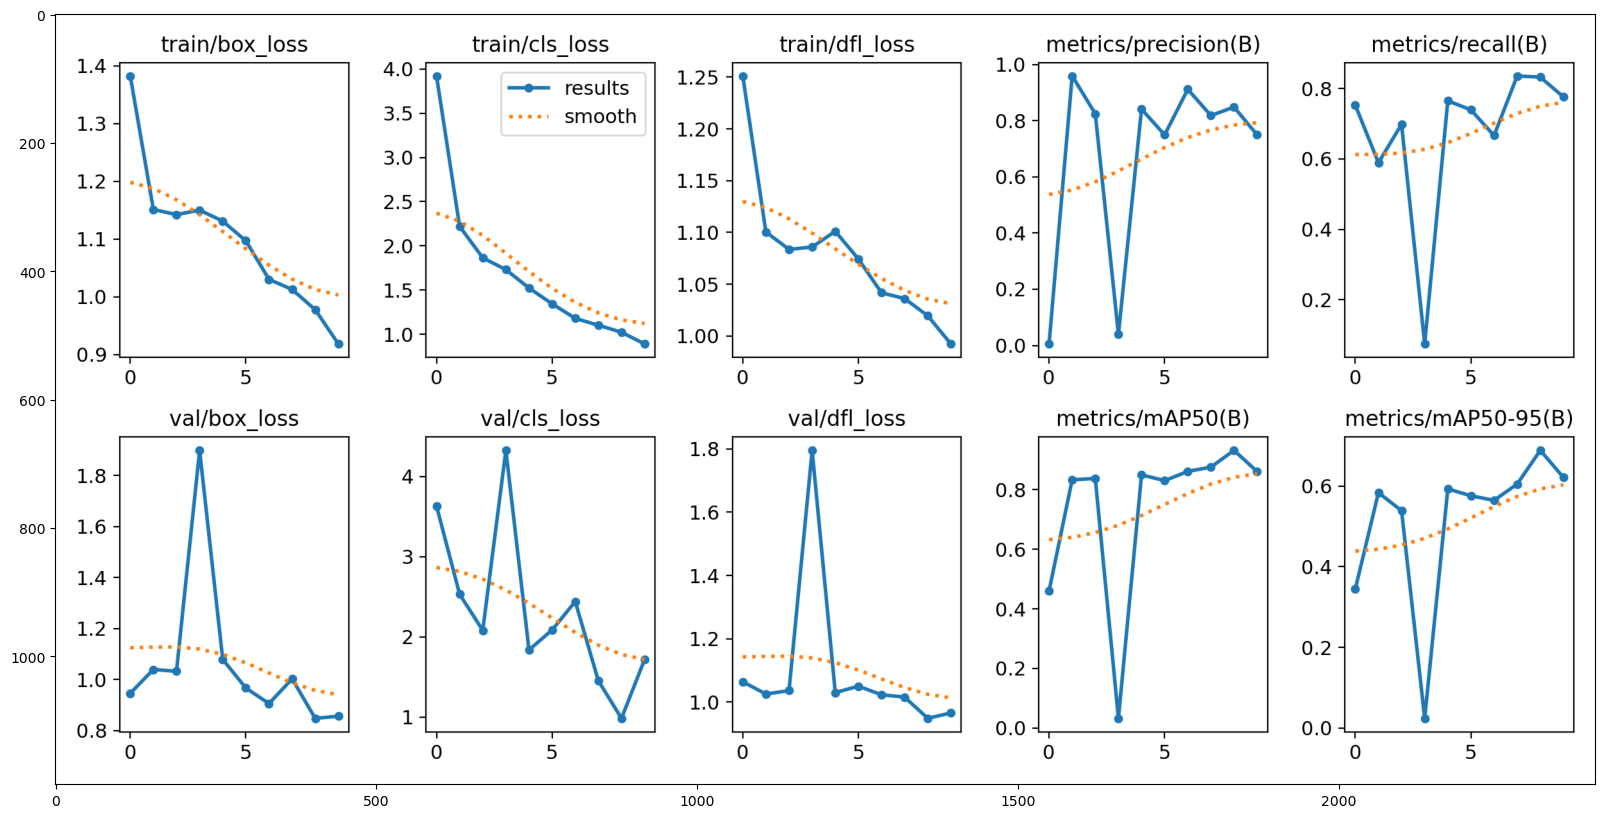

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

training_output_folder = 'runs/detect/train'

plt.figure(figsize=(20, 10))
img = Image.open(os.path.join(training_output_folder, 'results.png'))
plt.imshow(img)
plt.show()

In [18]:
def show_subfolders(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for dir in dirs:
            print(os.path.join(root, dir))

# Specify the folder path
folder_path = '/kaggle/working/runs'

# Call the function to show subfolders
show_subfolders(folder_path)

/kaggle/working/runs/detect

/kaggle/working/runs/detect/val

/kaggle/working/runs/detect/val2

/kaggle/working/runs/detect/train

/kaggle/working/runs/detect/train/weights

In [2]:
# val_label = Image.open("/kaggle/working/runs/detect/val/val_batch0_labels.jpg")
# val_pred = Image.open("/kaggle/working/runs/detect/val/val_batch0_pred.jpg")

# plt.figure(figsize=(20,10))
# plt.imshow(val_label)
# plt.title("Label")
# plt.axis(False)
# plt.show()

# plt.figure(figsize=(20,10))
# plt.imshow(val_pred)
# plt.title("Prediction")
# plt.axis(False)
# plt.show()

<h2> Faster R-CNN </h2>

In [12]:
def loadData(dataset_dir, subset):

    df = pd.DataFrame(columns=['ID', 'label', 'X_center', 'Y_center', 'width', 'height'])

    dataset_dir = os.path.join(dataset_dir, subset)
    for filename in os.listdir(dataset_dir):
        file_name_full_path = os.path.join(dataset_dir, filename)
        with open(file_name_full_path, 'r') as file:
            # we need to seperate lines; some lables has more than 1 row 
            # since there are more than one tumor observed in the image
            lines = file.read().splitlines()
            for line in lines:
                file_contents = line.split()
                float_list = list(map(float, file_contents))
                # adding the label as the first element in the list as ID
                float_list.insert(0, filename.split(".")[0])
                df.loc[len(df)] = float_list
    df['label'] = df['label'].astype(int)            
    return df            

In [13]:
train_dir = '/kaggle/working/train'
valid_dir = '/kaggle/working/valid'
subset = 'labels'
df_YOLO_train = loadData(train_dir, subset)
df_YOLO_val   = loadData(valid_dir, subset)
df_YOLO_train

,ID,label,X_center,Y_center,width,height
0,00334_121_rotated_v,1,0.442879,0.369718,0.136150,0.075117
1,00291_24_rotated_v,1,0.460997,0.243545,0.124233,0.111502
2,00123_10_rotated_h,0,0.789319,0.495892,0.118545,0.080986
3,00263_117_rotated_v,1,0.418623,0.452465,0.222222,0.153756
4,00130_100_rotated_h,0,0.655516,0.665493,0.158451,0.185446
...,...,...,...,...,...,...
922,00116_15_rotated_v,0,0.325509,0.345070,0.139280,0.133803
923,00313_133,1,0.516432,0.788732,0.111111,0.079812
924,00150_10,0,0.383568,0.460094,0.125196,0.199531
925,00360_102,1,0.625196,0.667840,0.228482,0.199531


In [14]:
print(f"Total 'positive' labels: {sum(df_YOLO_train.label == 1)}")
print(f"Total 'negative' labels: {sum(df_YOLO_train.label == 0)}")

Total 'positive' labels: 558

Total 'negative' labels: 369

In [15]:
def convert_bbox_YOLO_2_FasterRCNN(df,path):
    
    new_df = df.copy()

    new_df['xmin'] = df['X_center'] - (df['width'] / 2)
    new_df['ymin'] = df['Y_center'] - (df['height'] / 2)
    new_df['xmax'] = df['X_center'] + (df['width'] / 2)
    new_df['ymax'] = df['Y_center'] + (df['height'] / 2)
    new_df.drop(['X_center', 'Y_center', 'width', 'height'], axis = 1 , inplace = True)
    
        
    for index, row in new_df.iterrows():
        img_path = os.path.join(path, row['ID'] + '.jpg')
        image = cv2.imread(img_path)
        
#         new_df['xmin'].iloc[index] = new_df['xmin'].iloc[index] * image.shape[1]
#         new_df['xmax'].iloc[index] = new_df['xmax'].iloc[index] * image.shape[1]
#         new_df['ymin'].iloc[index] = new_df['ymin'].iloc[index] * image.shape[0]
#         new_df['ymax'].iloc[index] = new_df['ymax'].iloc[index] * image.shape[0]

        new_df['xmin'].iloc[index] = new_df['xmin'].iloc[index] 
        new_df['xmax'].iloc[index] = new_df['xmax'].iloc[index] 
        new_df['ymin'].iloc[index] = new_df['ymin'].iloc[index] 
        new_df['ymax'].iloc[index] = new_df['ymax'].iloc[index] 

    return new_df

In [16]:

df_faster_train = convert_bbox_YOLO_2_FasterRCNN(df_YOLO_train, images_folder_train)
df_faster_val   = convert_bbox_YOLO_2_FasterRCNN(df_YOLO_val, images_folder_valid)
df_faster_train

,ID,label,xmin,ymin,xmax,ymax
0,00334_121_rotated_v,1,0.374804,0.332159,0.510954,0.407276
1,00291_24_rotated_v,1,0.398880,0.187794,0.523114,0.299296
2,00123_10_rotated_h,0,0.730047,0.455399,0.848591,0.536385
3,00263_117_rotated_v,1,0.307512,0.375587,0.529734,0.529343
4,00130_100_rotated_h,0,0.576291,0.572770,0.734741,0.758216
...,...,...,...,...,...,...
922,00116_15_rotated_v,0,0.255869,0.278168,0.395149,0.411971
923,00313_133,1,0.460877,0.748826,0.571987,0.828638
924,00150_10,0,0.320970,0.360328,0.446166,0.559859
925,00360_102,1,0.510955,0.568075,0.739437,0.767605


In [17]:
class MyDataset(Dataset):
#     w , h = 192 , 192
    def __init__(self, dataframe, root, transform):
        self.image_dir = root
        self.dataframe = dataframe
        self.transform = transform
        self.img_paths = glob.glob(self.image_dir + '/*.jpg')
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):

        row = self.dataframe.iloc[index]
        image_id = row['ID']
        label = row['label']
        img_path = f'{self.image_dir}/{image_id}.jpg'
        
        # Load image here using image_id
        
        im = cv2.imread(img_path)
#         print(image)
        
#         original_width, original_height = im.shape[0], im.shape[1]
#         w_scale = self.w / original_width
#         h_scale = self.h / original_height
        
        image = Image.open(img_path)
#         image = np.array(image.resize((self.w ,self.h) , resample = Image.BILINEAR))/255

        
#         xmin, ymin, xmax, ymax = row['xmin'] * w_scale , row['ymin'] * h_scale, row['xmax'] * w_scale, row['ymax'] * h_scale
        
        xmin, ymin, xmax, ymax = row['xmin'] , row['ymin'], row['xmax'], row['ymax']
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        # Create target dictionary
        target = {
            'boxes': torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),
            'labels': torch.tensor([label], dtype=torch.int64)
        }
        
        return image, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))
    

In [18]:
 # Create an instance of the custom dataset
# path_train = "../input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/train"  
# path_val   = "../input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"

ds_train = MyDataset(df_faster_train, images_folder_train, transform=ToTensor())
ds_val   = MyDataset(df_faster_val, images_folder_valid, transform=ToTensor())


train_loader = DataLoader(ds_train, batch_size=16, shuffle=True, collate_fn=ds_train.collate_fn)
val_loader = DataLoader(ds_val, batch_size=16, shuffle=True, collate_fn=ds_val.collate_fn)


In [19]:
# Create the Faster RCNN model
num_classes = 2

def get_model():
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # adding dropout to model
    model.roi_heads.box_predictor.cls_score = nn.Sequential(
        nn.Dropout(0.5),
        model.roi_heads.box_predictor.cls_score)
    return model

model =get_model().to(device)

# Define the optimizer and learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-04)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.SmoothL1Loss()

# Training loop
num_epochs = 5
train_loss_tensor, val_loss_tensor = [], []
log = Report(num_epochs)
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = list(image.to(device, dtype=torch.float) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        # Forward pass
        loss_dict_train = model(images, targets)

        # Compute total loss
        total_loss_train = sum(loss for loss in loss_dict_train.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss_train.backward()
        optimizer.step()

    # Update learning rate
#     lr_scheduler.step()

    # Validation loop
    model.train()
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device, dtype=torch.float) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict_val = model(images, targets)

            # Compute total loss
#             total_loss_val = sum(loss for loss in loss_dict_val.values())
            total_loss_val = sum(loss for loss in loss_dict_val.values())
        

            # Update validation metrics (if needed)

    # Print training/validation statistics (if needed)
    train_loss_tensor.append(total_loss_train)
    val_loss_tensor.append(total_loss_val)
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss_train: {total_loss_train}, Loss_val: {total_loss_val}")


train_loss = [tensor.item() for tensor in train_loss_tensor]
val_loss   = [tensor.item() for tensor in val_loss_tensor]
epochs = [i  for i in range(1,num_epochs + 1)]
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model (if needed)
# torch.save(model.state_dict(), 'faster_rcnn_model.pth')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 54.6MB/s] 


Epoch: 1/5, Loss_train: 0.1426415890455246, Loss_val: 0.42334601283073425

Epoch: 2/5, Loss_train: 0.17638899385929108, Loss_val: 0.2821713984012604

OutOfMemoryError: CUDA out of memory. Tried to allocate 850.00 MiB (GPU 0; 15.90 GiB total capacity; 11.37 GiB already allocated; 563.75 MiB free; 14.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF